In [10]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
from statsmodels.stats.anova import AnovaRM
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.signal import find_peaks, peak_prominences, peak_widths
from scipy.integrate import trapezoid
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import iqr
import math

In [11]:
def load_and_normalize_data(filepath):
    gpc_df = pd.read_csv(filepath)
    index_labels = gpc_df.index
    gpc_RI = gpc_df.filter(regex='RI_' ) 
    gpc_time = gpc_df.filter(regex='Time\[min\]_')

    # Subtract min and divide by max-min for each row to normalize
    gpc_RI_Normalized = (gpc_RI.subtract(gpc_RI.min(axis=1), axis=0)
                                .div(gpc_RI.max(axis=1) - gpc_RI.min(axis=1), axis=0))
    
    return gpc_time, gpc_RI_Normalized, index_labels

filepath = "/Users/suhasmathey/Library/CloudStorage/OneDrive-UniversityofDelaware-o365/Spring_24/ELEG848 Soft Materials Inn/GPC Data/GPC_final.csv"
gpc_time, gpc_RI, index_labels = load_and_normalize_data(filepath)

print(gpc_RI)
print(gpc_time)
print(index_labels)

        RI_1      RI_2      RI_3      RI_4      RI_5      RI_6      RI_7  \
0   0.007986  0.007140  0.005597  0.004216  0.003291  0.002737  0.002305   
1   0.032037  0.032037  0.029748  0.027460  0.025172  0.025172  0.025172   
2   0.061855  0.060883  0.058992  0.057160  0.056012  0.055627  0.055305   
3   0.068777  0.067242  0.064050  0.061280  0.059861  0.059107  0.058619   
4   0.076819  0.074933  0.071565  0.068855  0.067317  0.066368  0.065905   
5   0.016988  0.016642  0.015587  0.013936  0.012781  0.012215  0.011752   
6   0.006880  0.006557  0.005660  0.004407  0.003456  0.002841  0.002433   
7   0.101912  0.095133  0.088389  0.086424  0.086920  0.089239  0.086500   
8   0.013797  0.013079  0.011014  0.008923  0.007973  0.007770  0.007950   
9   0.011671  0.010738  0.008652  0.006752  0.005694  0.004947  0.004613   
10  0.016175  0.015840  0.015064  0.014223  0.013681  0.013416  0.013236   
11  0.015565  0.015329  0.014558  0.013524  0.012784  0.012409  0.012279   

        RI_

In [12]:
def bin_normalized_data(data, ppm_values, bin_size):
    binned_areas = []
    total_points = data.shape[1]
    num_full_bins = total_points // bin_size
    remaining_points = total_points % bin_size

    # Iterate over each sample in the dataset
    for sample_index in range(data.shape[0]):
        sample_areas = []

        # Iterate over each full bin
        for bin_index in range(num_full_bins):
            start_index = bin_index * bin_size
            end_index = start_index + bin_size

            # Extract the intensities and corresponding x-values for the current bin and sample
            current_bin_data = data.iloc[sample_index, start_index:end_index]
            current_bin_ppm = ppm_values.iloc[:, start_index:end_index]

            # Calculate the area under the curve using np.trapz
            area = np.trapz(current_bin_data, current_bin_ppm.iloc[0])  # Use the first row if PPM values are constant across samples
            sample_areas.append(area)

        # Handle remaining points for the last bin if they exist
        if remaining_points > 0:
            start_index = num_full_bins * bin_size
            end_index = start_index + remaining_points
            current_bin_data = data.iloc[sample_index, start_index:end_index]
            current_bin_ppm = ppm_values.iloc[:, start_index:end_index]

            # Calculate the area under the curve for the last bin
            area = np.trapz(current_bin_data, current_bin_ppm.iloc[0])
            sample_areas.append(area)

        # Append the binned areas for the current sample
        binned_areas.append(sample_areas)

    # Convert the list of lists to a DataFrame with bin labels
    bin_labels = [f'Area_Bin_{i+1}' for i in range(num_full_bins + (1 if remaining_points > 0 else 0))]
    return pd.DataFrame(binned_areas, columns=bin_labels)


binned_data = bin_normalized_data(gpc_RI, gpc_time, bin_size=300)
print(binned_data)


    Area_Bin_1  Area_Bin_2  Area_Bin_3  Area_Bin_4  Area_Bin_5  Area_Bin_6  \
0     0.048206    0.090418    0.100980    0.102138    0.077232    0.027231   
1     0.081226    0.081949    0.098529    0.103648    0.062247    0.035459   
2     0.135511    0.117988    0.116757    0.121076    0.102462    0.052070   
3     0.164947    0.262640    0.330383    0.262434    0.268032    0.279861   
4     0.158673    0.135536    0.033476    0.037760    0.117231    0.029879   
5     0.038771    0.069693    0.059836    0.040070    0.014946    0.066953   
6     0.008751    0.028422    0.049899    0.028786    0.033038    0.036207   
7     0.316277    0.214254    0.254737    0.331916    0.461661    0.235327   
8     0.094188    0.169343    0.198216    0.219218    0.279089    0.169608   
9     0.026280    0.017998    0.094181    0.077978    0.110254    0.087350   
10    0.053568    0.062820    0.057613    0.043109    0.025525    0.004596   
11    0.049097    0.048181    0.062022    0.067466    0.042409  

         PC1       PC2       PC3
0  -1.115111  0.120141 -0.271427
1  -0.507052  0.209745  0.800565
2   1.657799 -0.377466  0.182592
3  -0.550747  0.953007 -0.155414
4  -0.627349  0.499034  0.054149
5  -0.957657 -0.125236 -0.211680
6  -1.182456 -0.478634 -0.312141
7   1.690003  0.119441 -0.102221
8   1.602499  0.093748 -0.062900
9   1.829011 -0.096715 -0.183236
10 -0.851429 -0.460633  0.325229
11 -0.987510 -0.456433 -0.063515
[0.8283087  0.09604248 0.05022162]


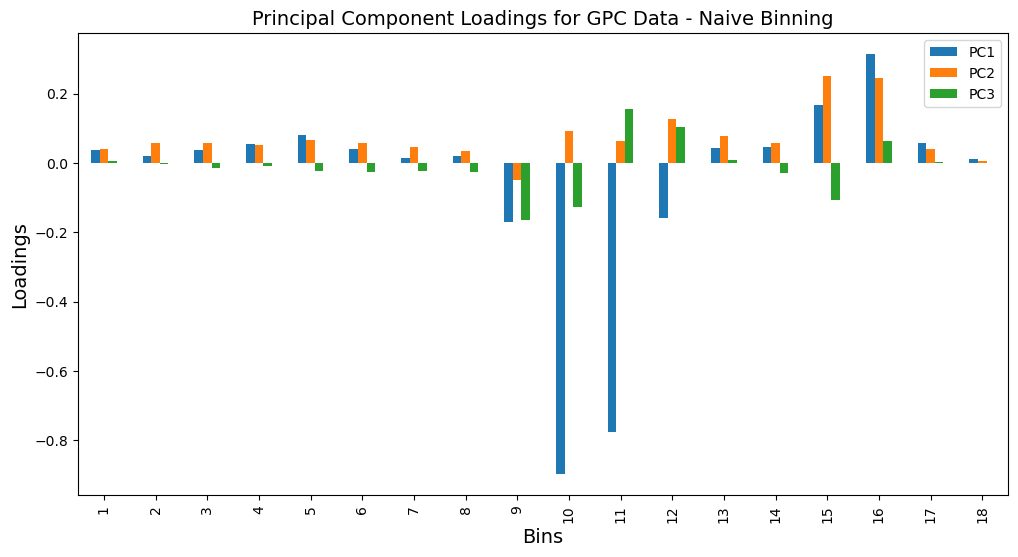

In [13]:
binned_data.columns = [col.replace('Bin', 'Peak') for col in binned_data.columns]

binned_data.columns = [str(i+1) for i in range(len(binned_data.columns))]


pca = PCA(n_components=3)
principal_components = pca.fit_transform(binned_data)

principal_components_df = pd.DataFrame(principal_components,index=index_labels, columns=['PC1', 'PC2', 'PC3'])
print(principal_components_df)
print(pca.explained_variance_ratio_)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3'], index=binned_data.columns)

fig, ax = plt.subplots(figsize=(12,6))
loading_matrix.plot(kind='bar', ax=ax)
plt.title('Principal Component Loadings for GPC Data - Naive Binning', fontsize=14)
plt.ylabel('Loadings', fontsize=14)
plt.xlabel('Bins', fontsize=14)
plt.show()

In [14]:
principal_components_df.to_csv("/Users/suhasmathey/Library/CloudStorage/OneDrive-UniversityofDelaware-o365/Spring_24/ELEG848 Soft Materials Inn/GPC Data/PC_naive_GPC.csv")

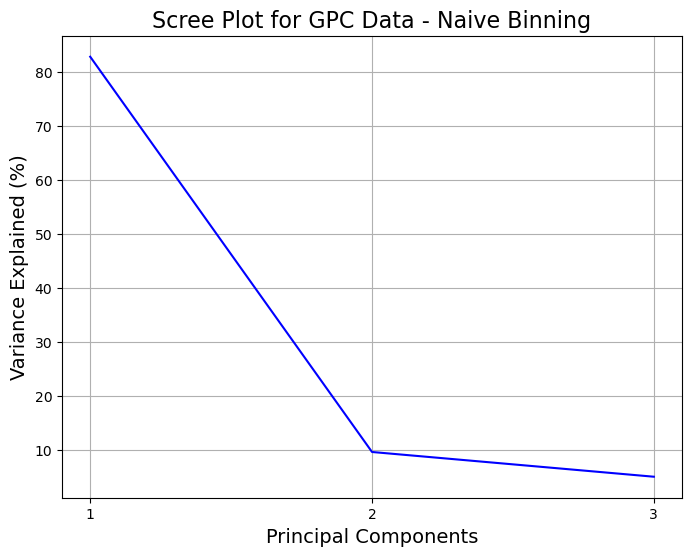

In [15]:
explained_variance = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(1, len(explained_variance)+1), explained_variance*100, color='blue')
plt.xlabel('Principal Components', fontsize=14)
plt.ylabel('Variance Explained (%)', fontsize=14)
plt.title('Scree Plot for GPC Data - Naive Binning', fontsize=16)
plt.xticks(range(1, len(explained_variance)+1))  # Ensure ticks correspond to components
plt.grid(True)
plt.show()

In [16]:
performance_data = pd.read_csv("/Users/suhasmathey/Library/CloudStorage/OneDrive-UniversityofDelaware-o365/Spring_24/ELEG848 Soft Materials Inn/NMR_Data/tidy_performance_2.0.csv", index_col='Sample')
Y = performance_data['Performance (mean)']
X  = principal_components

Y.reset_index(drop=True, inplace=True)


poly = PolynomialFeatures(degree=1)
X_LP = poly.fit_transform(X)

C = sm.add_constant(X_LP)
ols_model = sm.OLS(Y, C).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:     Performance (mean)   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     3.315
Date:                Tue, 14 May 2024   Prob (F-statistic):             0.0778
Time:                        10:55:37   Log-Likelihood:                -25.784
No. Observations:                  12   AIC:                             59.57
Df Residuals:                       8   BIC:                             61.51
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.1333      0.733     21.996      0.0

/Users/suhasmathey/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  k, _ = kurtosistest(a, axis)


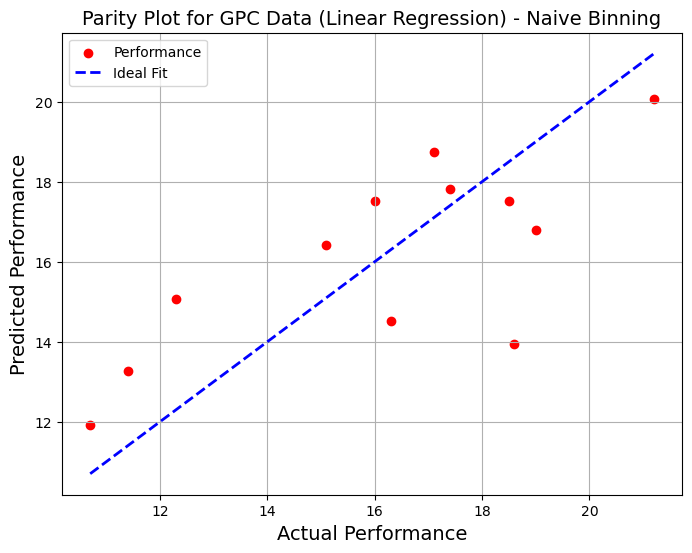

In [17]:
lin_reg = LinearRegression()
lin_reg.fit(X_LP, Y)

Y_pred = lin_reg.predict(X_LP)

plt.figure(figsize=(8, 6))
plt.scatter(Y, Y_pred, color= 'Red', label='Performance')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'b--', lw=2, label='Ideal Fit')

plt.xlabel('Actual Performance', fontsize=14)
plt.ylabel('Predicted Performance', fontsize=14)
plt.title('Parity Plot for GPC Data (Linear Regression) - Naive Binning', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [18]:
Y_pred

array([14.50759606, 20.07293591, 16.79592819, 18.74767788, 17.82491822,
       13.93402201, 11.92111393, 17.52004569, 17.52145522, 16.42642374,
       15.06679409, 13.26108906])